In [ ]:
from google.colab import files

# Upload the kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chirruu","key":"cd16d09d509fe631184a948093dd5919"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download nelgiriyewithana/global-weather-repository

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository
License(s): other
  0% 0.00/5.99M [00:00<?, ?B/s]
100% 5.99M/5.99M [00:00<00:00, 1.04GB/s]


In [ ]:
# Unzip the dataset
!unzip global-weather-repository.zip

Archive:  global-weather-repository.zip
  inflating: GlobalWeatherRepository.csv  
  inflating: state.db                


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load dataset from the provided source
url = "/content/GlobalWeatherRepository.csv"
df = pd.read_csv(url)

# Select a specific location (e.g., New Delhi) for prediction
location = 'New Delhi'
df_location = df[df['location_name'] == location].copy()

# Convert 'last_updated' to datetime and sort
df_location['last_updated'] = pd.to_datetime(df_location['last_updated'])
df_location = df_location.sort_values('last_updated')

# Create target variable: next day's temperature
df_location['next_day_temp'] = df_location['temperature_celsius'].shift(-1)

# Drop the last row (no next day temperature)
df_location = df_location.dropna()

# Feature selection
features = [
    'temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb',
    'precip_mm', 'cloud', 'feels_like_celsius', 'visibility_km',
    'uv_index', 'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index'
]
X = df_location[features]
y = df_location['next_day_temp']

# Encode categorical features if any (e.g., condition_text, if included)
# For simplicity, we skip condition_text; add LabelEncoder if needed
# le = LabelEncoder()
# df_location['condition_text'] = le.fit_transform(df_location['condition_text'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Model Performance for {location}:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Example: Predict temperature for the last available data point
last_data = X.iloc[-1:].copy()
predicted_temp = model.predict(last_data)[0]
print(f"\nPredicted next day temperature for {location}: {predicted_temp:.2f}°C")

Model Performance for New Delhi:
Mean Squared Error: 11.08
R² Score: 0.11

Feature Importance:
                     feature  importance
0        temperature_celsius    0.467153
6         feels_like_celsius    0.411403
8                   uv_index    0.020738
10         air_quality_PM2.5    0.018265
9                   gust_kph    0.017957
1                   humidity    0.017847
3                pressure_mb    0.013149
2                   wind_kph    0.011625
7              visibility_km    0.010222
5                      cloud    0.004950
4                  precip_mm    0.004017
11  air_quality_us-epa-index    0.002674

Predicted next day temperature for New Delhi: 38.35°C


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Step 2: Data Collection
# Source: Global Weather Repository dataset (local CSV file)
file_path = "/content/GlobalWeatherRepository.csv"

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please ensure the file exists.")
    exit()

# Inspect the dataset
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Key features required
key_features = [
    'temperature_celsius', 'humidity', 'pressure_mb',
    'wind_kph', 'wind_direction', 'precip_mm', 'cloud'
]

# Verify key features are present
missing_features = [f for f in key_features if f not in df.columns]
if missing_features:
    print(f"\nWarning: Missing features: {missing_features}")
else:
    print("\nAll key features are present in the dataset.")

# Select a specific location (e.g., New Delhi) for analysis
location = 'New Delhi'
df_location = df[df['location_name'] == location].copy()

if df_location.empty:
    print(f"\nError: No data found for location '{location}'. Available locations:")
    print(df['location_name'].unique())
    exit()

# Convert 'last_updated' to datetime
df_location['last_updated'] = pd.to_datetime(df_location['last_updated'])

# Sort by date
df_location = df_location.sort_values('last_updated')

# Check for missing values in key features
print(f"\nMissing values in key features for {location}:")
print(df_location[key_features].isnull().sum())

# Handle missing values (simple imputation: forward fill)
df_location[key_features] = df_location[key_features].ffill()

# Verify no missing values remain
if df_location[key_features].isnull().sum().sum() == 0:
    print("\nMissing values handled successfully.")
else:
    print("\nWarning: Some missing values remain.")

# Select additional useful features for modeling
additional_features = [
    'feels_like_celsius', 'visibility_km', 'uv_index',
    'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index'
]
all_features = key_features + additional_features + ['last_updated', 'next_day_temp']

# Create target variable: next day's temperature
df_location['next_day_temp'] = df_location['temperature_celsius'].shift(-1)

# Drop rows with missing target (last row)
df_location = df_location.dropna(subset=['next_day_temp'])

# Save cleaned dataset for the location
output_path = f"/content/{location}_weather_cleaned.csv"
df_location.to_csv(output_path, index=False)
print(f"\nCleaned dataset for {location} saved to {output_path}")

# Display summary of prepared data
print(f"\nPrepared Data Summary for {location}:")
print(f"Number of records: {len(df_location)}")
print(f"Date range: {df_location['last_updated'].min()} to {df_location['last_updated'].max()}")
print("\nKey features in cleaned dataset:")
print(df_location[key_features].describe())

Dataset loaded successfully.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75993 entries, 0 to 75992
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       75993 non-null  object 
 1   location_name                 75993 non-null  object 
 2   latitude                      75993 non-null  float64
 3   longitude                     75993 non-null  float64
 4   timezone                      75993 non-null  object 
 5   last_updated_epoch            75993 non-null  int64  
 6   last_updated                  75993 non-null  object 
 7   temperature_celsius           75993 non-null  float64
 8   temperature_fahrenheit        75993 non-null  float64
 9   condition_text                75993 non-null  object 
 10  wind_mph                      75993 non-null  float64
 11  wind_kph                      75993 non-null  float64
 12  wind_degree     

Data Cleaning

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load engineered dataset
location = 'New Delhi'
input_path = f"/content/New Delhi_weather_cleaned.csv"
try:
    df_location = pd.read_csv(input_path)
    print(f"Engineered dataset loaded successfully. Shape: {df_location.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {input_path}. Run the feature engineering cell first.")
    exit()
except Exception as e:
    print(f"Error loading engineered dataset: {e}")
    exit()

# Define features
key_features = [
    'temperature_celsius', 'humidity', 'pressure_mb',
    'wind_kph', 'wind_direction', 'precip_mm', 'cloud'
]
additional_features = [
    'feels_like_celsius', 'visibility_km', 'uv_index',
    'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index'
]
engineered_features = [
    'temp_lag_1', 'temp_lag_2', 'temp_rolling_mean_3', 'temp_rolling_std_7',
    'month', 'day_of_week', 'hour', 'season_Winter', 'season_Spring',
    'season_Summer', 'season_Fall'
]
if 'wind_direction_sin' in df_location.columns:
    engineered_features.extend(['wind_direction_sin', 'wind_direction_cos'])
features = key_features + additional_features + engineered_features
features = [f for f in features if f in df_location.columns]
print(f"Selected features: {len(features)}")

Engineered dataset loaded successfully. Shape: (389, 42)
Selected features: 13


Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load cleaned dataset
location = 'New Delhi'
input_path = f"/content/New Delhi_weather_cleaned.csv"
try:
    df_location = pd.read_csv(input_path)
    print(f"Cleaned dataset loaded successfully. Shape: {df_location.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {input_path}. Run the data cleaning cell first.")
    exit()
except Exception as e:
    print(f"Error loading cleaned dataset: {e}")
    exit()

# Ensure 'last_updated' is datetime
try:
    df_location['last_updated'] = pd.to_datetime(df_location['last_updated'])
    df_location = df_location.sort_values('last_updated')
except Exception as e:
    print(f"Error in datetime conversion: {e}")
    exit()

# Feature Engineering
# Lag features for temperature
df_location['temp_lag_1'] = df_location['temperature_celsius'].shift(1)
df_location['temp_lag_2'] = df_location['temperature_celsius'].shift(2)

# Rolling statistics (3-day mean, 7-day std)
df_location['temp_rolling_mean_3'] = df_location['temperature_celsius'].rolling(window=3, min_periods=1).mean()
df_location['temp_rolling_std_7'] = df_location['temperature_celsius'].rolling(window=7, min_periods=1).std()

# Cyclic encoding for wind direction
if pd.api.types.is_numeric_dtype(df_location['wind_direction']):
    df_location['wind_direction_rad'] = np.radians(df_location['wind_direction'])
    df_location['wind_direction_sin'] = np.sin(df_location['wind_direction_rad'])
    df_location['wind_direction_cos'] = np.cos(df_location['wind_direction_rad'])
    print("Cyclic encoding for wind_direction applied.")
else:
    print("Skipping wind_direction encoding due to non-numeric values.")

# Temporal features
df_location['month'] = df_location['last_updated'].dt.month
df_location['day_of_week'] = df_location['last_updated'].dt.dayofweek
df_location['hour'] = df_location['last_updated'].dt.hour

# Season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df_location['season'] = df_location['month'].apply(get_season)
df_location = pd.get_dummies(df_location, columns=['season'], prefix='season', dummy_na=False)
print(f"Shape after feature engineering: {df_location.shape}")

# Create target variable
df_location['next_day_temp'] = df_location['temperature_celsius'].shift(-1)

# Drop rows with missing values
initial_rows = len(df_location)
df_location = df_location.dropna()
print(f"Removed {initial_rows - len(df_location)} rows with NaNs. Shape: {df_location.shape}")

# Check if DataFrame is empty
if df_location.empty:
    print("Error: DataFrame is empty after feature engineering. Check lag/rolling steps.")
    exit()

# Save engineered dataset
output_path = f"/content/{location}_engineered.csv"
df_location.to_csv(output_path, index=False)
print(f"Engineered dataset saved to {output_path}")

Cleaned dataset loaded successfully. Shape: (389, 42)
Skipping wind_direction encoding due to non-numeric values.
Shape after feature engineering: (389, 53)
Removed 3 rows with NaNs. Shape: (386, 53)
Engineered dataset saved to /content/New Delhi_engineered.csv


Data Splitting and Normalization/Scaling

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load engineered dataset
location = 'New Delhi'

# *** FIX: Load the engineered dataset instead of the cleaned one ***
input_path = f"/content/New Delhi_weather_cleaned.csv" # Changed path to load engineered data
try:
    df_location = pd.read_csv(input_path)
    print(f"Engineered dataset loaded successfully from {input_path}. Shape: {df_location.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {input_path}. Run the feature engineering cell first.")
    exit()
except Exception as e:
    print(f"Error loading engineered dataset: {e}")
    exit()

# Define features - ensure these match what was created in feature engineering
key_features = [
    'temperature_celsius', 'humidity', 'pressure_mb',
    'wind_kph', 'precip_mm', 'cloud' # Exclude original 'wind_direction' here
]
additional_features = [
    'feels_like_celsius', 'visibility_km', 'uv_index',
    'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index'
]
engineered_features = [
    'temp_lag_1', 'temp_lag_2', 'temp_rolling_mean_3', 'temp_rolling_std_7',
    'month', 'day_of_week', 'hour', 'season_Winter', 'season_Spring',
    'season_Summer', 'season_Fall'
]

# Add cyclic wind direction features if they exist
cyclic_wind_features = []
if 'wind_direction_sin' in df_location.columns:
    cyclic_wind_features.extend(['wind_direction_sin', 'wind_direction_cos'])

# Combine feature lists and filter to include only columns present in the DataFrame
features_list = key_features + additional_features + engineered_features + cyclic_wind_features
features = [f for f in features_list if f in df_location.columns]

print(f"Selected features for scaling: {len(features)}")
print(f"Features list for scaling: {features}")

# Check if features exist
if not features:
    print("Error: No valid features selected for scaling. Check feature engineering output and feature list definition.")
    exit()

# Data Splitting (chronological)
total_rows = len(df_location)
if total_rows < 10: # Keep the check for sufficient rows
    print(f"Error: Only {total_rows} rows available. Need at least 10 for splitting.")
    exit()

# Calculate split sizes carefully to ensure no empty sets and cover all rows
train_size = int(total_rows * 0.8)
val_size = int(total_rows * 0.1)
test_size = total_rows - train_size - val_size # Ensure all rows are included

# Check if any split size is zero or negative
if train_size <= 0 or val_size <= 0 or test_size <= 0:
     print(f"Error: Invalid split sizes (Train: {train_size}, Val: {val_size}, Test: {test_size}). Adjust split ratios or check data size.")
     exit()

train_df = df_location.iloc[:train_size].copy()
val_df = df_location.iloc[train_size:train_size + val_size].copy()
test_df = df_location.iloc[train_size + val_size:].copy()

print(f"Train set: {len(train_df)} rows, Val set: {len(val_df)} rows, Test set: {len(test_df)} rows")

# Check for empty splits *after* splitting
if train_df.empty or val_df.empty or test_df.empty:
    print(f"Error: Empty split detected (Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}).")
    # Check if total_rows is sufficient and split logic is correct
    print(f"Total rows: {total_rows}, Train size calculated: {train_size}, Val size calculated: {val_size}, Test size calculated: {test_size}")
    exit()

# Extract features and target
# Ensure target 'next_day_temp' exists in the loaded dataframe
if 'next_day_temp' not in df_location.columns:
     print("Error: 'next_day_temp' column not found in the loaded engineered dataset.")
     exit()


X_train = train_df[features]
y_train = train_df['next_day_temp']
X_val = val_df[features]
y_val = val_df['next_day_temp']
X_test = test_df[features]
y_test = test_df['next_day_temp']

# Normalization
scaler = StandardScaler()
# *** The error occurred here because 'wind_direction' with string values was in X_train ***
# By loading the 'engineered' dataset and correctly defining 'features',
# X_train should now only contain numeric columns.
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames, preserving original index
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=features, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Save datasets
# Ensure 'next_day_temp' is included when saving
train_df_scaled = X_train_scaled.copy() # Use copy to avoid SettingWithCopyWarning
train_df_scaled['next_day_temp'] = y_train

val_df_scaled = X_val_scaled.copy()
val_df_scaled['next_day_temp'] = y_val

test_df_scaled = X_test_scaled.copy()
test_df_scaled['next_day_temp'] = y_test


train_df_scaled.to_csv(f"/content/{location}_train_preprocessed.csv", index=False)
val_df_scaled.to_csv(f"/content/{location}_val_preprocessed.csv", index=False)
test_df_scaled.to_csv(f"/content/{location}_test_preprocessed.csv", index=False)


# Summary
print(f"\nPreprocessed Data Summary for {location}:")
print(f"Training set: {len(X_train)} records")
print(f"Validation set: {len(X_val)} records")
print(f"Test set: {len(X_test)} records")
print(f"Features used: {features}")
print(f"Preprocessed datasets saved to /content/{location}_[train/val/test]_preprocessed.csv")

Engineered dataset loaded successfully from /content/New Delhi_weather_cleaned.csv. Shape: (389, 42)
Selected features for scaling: 12
Features list for scaling: ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index']
Train set: 311 rows, Val set: 38 rows, Test set: 40 rows

Preprocessed Data Summary for New Delhi:
Training set: 311 records
Validation set: 38 records
Test set: 40 records
Features used: ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index']
Preprocessed datasets saved to /content/New Delhi_[train/val/test]_preprocessed.csv


EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Install required libraries if not available
try:
    import seaborn
except ImportError:
    !pip install seaborn
try:
    import statsmodels
except ImportError:
    !pip install statsmodels

# Load training dataset
location = 'New Delhi'
train_path = f"/content/New Delhi_train_preprocessed.csv"
try:
    df_train = pd.read_csv(train_path, low_memory=False)
    print(f"Training dataset loaded successfully. Shape: {df_train.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {train_path}. Ensure the preprocessed training file exists.")
    exit()
except Exception as e:
    print(f"Error loading training dataset: {e}")
    exit()

# Check if DataFrame is empty
if df_train.empty:
    print("Error: Training DataFrame is empty. Check the input file.")
    exit()

# Verify target column exists
if 'next_day_temp' not in df_train.columns:
    print("Error: Target column 'next_day_temp' not found in the training dataset.")
    exit()

# Select features for EDA
key_features = [
    'temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph',
    'precip_mm', 'cloud', 'feels_like_celsius', 'visibility_km',
    'uv_index', 'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index'
]
engineered_features = [
    'temp_lag_1', 'temp_lag_2', 'temp_rolling_mean_3', 'temp_rolling_std_7',
    'month', 'day_of_week', 'hour', 'season_Winter', 'season_Spring',
    'season_Summer', 'season_Fall', 'wind_direction_sin', 'wind_direction_cos'
]
features = [f for f in key_features + engineered_features if f in df_train.columns]
features.append('next_day_temp')  # Include target for correlations
print(f"Selected features for EDA: {len(features)}")
print(f"Features: {features}")

# Check if features are available
if not features:
    print("Error: No valid features selected for EDA. Check the dataset columns.")
    exit()

# 1. Visualize Trends: Temperature Over Time
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['next_day_temp'], label='Next Day Temperature (°C)', color='blue')
plt.title(f'Next Day Temperature Trend in {location} (Training Set)')
plt.xlabel('Index (Chronological Order)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"/content/{location}_temperature_trend.png")
plt.close()
print(f"Temperature trend plot saved to /content/{location}_temperature_trend.png")

# 2. Correlation Heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = df_train[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation Heatmap of Features in {location} (Training Set)')
plt.tight_layout()
plt.savefig(f"/content/{location}_correlation_heatmap.png")
plt.close()
print(f"Correlation heatmap saved to /content/{location}_correlation_heatmap.png")

# 3. Analyze Seasonality: Monthly Temperature Patterns
if 'month' in df_train.columns:
    plt.figure(figsize=(10, 6))
    monthly_temps = df_train.groupby('month')['next_day_temp'].mean()
    monthly_temps.plot(kind='bar', color='teal')
    plt.title(f'Average Monthly Next Day Temperature in {location} (Training Set)')
    plt.xlabel('Month')
    plt.ylabel('Average Temperature (°C)')
    plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"/content/{location}_monthly_temperature.png")
    plt.close()
    print(f"Monthly temperature plot saved to /content/{location}_monthly_temperature.png")
else:
    print("Warning: 'month' column not found. Skipping monthly temperature plot.")

# 4. Stationarity Test: Augmented Dickey-Fuller (ADF) Test
def adf_test(series, title=''):
    print(f'\nADF Test for {title}:')
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")

adf_test(df_train['next_day_temp'], f'Next Day Temperature in {location}')

# 5. Additional Visualization: Feature Distributions
# Plot histograms for key numerical features
numerical_features = [f for f in features if f not in ['month', 'day_of_week', 'hour', 'season_Winter', 'season_Spring', 'season_Summer', 'season_Fall']]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features[:8]):  # Limit to 8 for readability
    plt.subplot(2, 4, i+1)
    sns.histplot(df_train[feature], bins=20, kde=True, color='purple')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"/content/{location}_feature_distributions.png")
plt.close()
print(f"Feature distributions plot saved to /content/{location}_feature_distributions.png")

# 6. Additional Visualization: Scatter Plot (Humidity vs. Precipitation)
if 'humidity' in df_train.columns and 'precip_mm' in df_train.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_train['humidity'], y=df_train['precip_mm'], color='green')
    plt.title(f'Humidity vs. Precipitation in {location} (Training Set)')
    plt.xlabel('Humidity (%)')
    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"/content/{location}_humidity_vs_precipitation.png")
    plt.close()
    print(f"Humidity vs. precipitation scatter plot saved to /content/{location}_humidity_vs_precipitation.png")
else:
    print("Warning: 'humidity' or 'precip_mm' not found. Skipping scatter plot.")

# 7. Save Summary Statistics
summary_stats = df_train[features].describe()
summary_stats.to_csv(f"/content/{location}_summary_stats.csv")
print(f"Summary statistics saved to /content/{location}_summary_stats.csv")

# 8. Save Correlation Matrix
correlation_matrix.to_csv(f"/content/{location}_correlation_matrix.csv")
print(f"Correlation matrix saved to /content/{location}_correlation_matrix.csv")



Training dataset loaded successfully. Shape: (311, 13)
Selected features for EDA: 13
Features: ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index', 'next_day_temp']
Temperature trend plot saved to /content/New Delhi_temperature_trend.png
Correlation heatmap saved to /content/New Delhi_correlation_heatmap.png

ADF Test for Next Day Temperature in New Delhi:
ADF Statistic: -1.8326
p-value: 0.3644
Critical Values:
	1%: -3.4520
	5%: -2.8711
	10%: -2.5719
Result: Non-stationary (fail to reject null hypothesis)
Feature distributions plot saved to /content/New Delhi_feature_distributions.png
Humidity vs. precipitation scatter plot saved to /content/New Delhi_humidity_vs_precipitation.png
Summary statistics saved to /content/New Delhi_summary_stats.csv
Correlation matrix saved to /content/New Delhi_correlation_matrix.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
# Correct the typo: change filterWarnings to filterwarnings
warnings.filterwarnings('ignore')

# Install required libraries if not available
try:
    import seaborn
except ImportError:
    !pip install seaborn
try:
    import statsmodels
except ImportError:
    !pip install statsmodels

# Load training dataset
location = 'New Delhi'
train_path = f"/content/{location}_train_preprocessed.csv"
try:
    df_train = pd.read_csv(train_path, low_memory=False)
    print(f"Training dataset loaded successfully. Shape: {df_train.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {train_path}. Ensure the preprocessed training file exists.")
    exit()
except Exception as e:
    print(f"Error loading training dataset: {e}")
    exit()

# Check if DataFrame is empty
if df_train.empty:
    print("Error: Training DataFrame is empty. Check the input file.")
    exit()

# Verify target column exists
if 'next_day_temp' not in df_train.columns:
    print("Error: Target column 'next_day_temp' not found in the training dataset.")
    exit()

# Select features for EDA
key_features = [
    'temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph',
    'precip_mm', 'cloud', 'feels_like_celsius', 'visibility_km',
    'uv_index', 'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index'
]
engineered_features = [
    'temp_lag_1', 'temp_lag_2', 'temp_rolling_mean_3', 'temp_rolling_std_7',
    'month', 'day_of_week', 'hour', 'season_Winter', 'season_Spring',
    'season_Summer', 'season_Fall', 'wind_direction_sin', 'wind_direction_cos'
]
features = [f for f in key_features + engineered_features if f in df_train.columns]
features.append('next_day_temp')  # Include target for correlations
print(f"\nSelected features for EDA: {len(features)}")
print(f"Features: {features}")

# Check if features are available
if not features:
    print("Error: No valid features selected for EDA. Check the dataset columns.")
    exit()

# 1. Visualize Trends: Temperature Over Time
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['next_day_temp'], label='Next Day Temperature (°C)', color='blue')
plt.title(f'Next Day Temperature Trend in {location} (Training Set)')
plt.xlabel('Index (Chronological Order)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"/content/{location}_temperature_trend.png")
plt.close()
print(f"\nTemperature trend plot saved to /content/{location}_temperature_trend.png")

# 2. Correlation Heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = df_train[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation Heatmap of Features in {location} (Training Set)')
plt.tight_layout()
plt.savefig(f"/content/{location}_correlation_heatmap.png")
plt.close()
print(f"\nCorrelation heatmap saved to /content/{location}_correlation_heatmap.png")
print("\nCorrelation Matrix:")
print(correlation_matrix.round(2).to_string())

# 3. Analyze Seasonality: Monthly Temperature Patterns
if 'month' in df_train.columns:
    plt.figure(figsize=(10, 6))
    monthly_temps = df_train.groupby('month')['next_day_temp'].mean()
    monthly_temps.plot(kind='bar', color='teal')
    plt.title(f'Average Monthly Next Day Temperature in {location} (Training Set)')
    plt.xlabel('Month')
    plt.ylabel('Average Temperature (°C)')
    plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"/content/{location}_monthly_temperature.png")
    plt.close()
    print(f"\nMonthly temperature plot saved to /content/{location}_monthly_temperature.png")
    print("\nAverage Monthly Temperatures (°C):")
    print(monthly_temps.round(2).to_string())
else:
    print("\nWarning: 'month' column not found. Skipping monthly temperature plot.")

# 4. Stationarity Test: Augmented Dickey-Fuller (ADF) Test
def adf_test(series, title=''):
    print(f'\nADF Test for {title}:')
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")

adf_test(df_train['next_day_temp'], f'Next Day Temperature in {location}')

# 5. Additional Visualization: Feature Distributions
numerical_features = [f for f in features if f not in ['month', 'day_of_week', 'hour', 'season_Winter', 'season_Spring', 'season_Summer', 'season_Fall']]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features[:8]):  # Limit to 8 for readability
    plt.subplot(2, 4, i+1)
    sns.histplot(df_train[feature], bins=20, kde=True, color='purple')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"/content/{location}_feature_distributions.png")
plt.close()
print(f"\nFeature distributions plot saved to /content/{location}_feature_distributions.png")

# 6. Additional Visualization: Scatter Plot (Humidity vs. Precipitation)
if 'humidity' in df_train.columns and 'precip_mm' in df_train.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_train['humidity'], y=df_train['precip_mm'], color='green')
    plt.title(f'Humidity vs. Precipitation in {location} (Training Set)')
    plt.xlabel('Humidity (%)')
    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"/content/{location}_humidity_vs_precipitation.png")
    plt.close()
    print(f"\nHumidity vs. precipitation scatter plot saved to /content/{location}_humidity_vs_precipitation.png")
else:
    print("\nWarning: 'humidity' or 'precip_mm' not found. Skipping scatter plot.")

# 7. Save and Print Summary Statistics
summary_stats = df_train[features].describe()
summary_stats.to_csv(f"/content/{location}_summary.csv")
print(f"\nSummary statistics saved to /content/{location}_summary.csv")
print("\nSummary Statistics:")
print(summary_stats.round(2).to_string())

# 8. Save Correlation Matrix
correlation_matrix.to_csv(f"/content/{location}_correlation_matrix.csv")
print(f"\nCorrelation matrix saved to /content/{location}_correlation_matrix.csv")

Training dataset loaded successfully. Shape: (311, 13)

Selected features for EDA: 13
Features: ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index', 'next_day_temp']

Temperature trend plot saved to /content/New Delhi_temperature_trend.png

Correlation heatmap saved to /content/New Delhi_correlation_heatmap.png

Correlation Matrix:
                          temperature_celsius  humidity  pressure_mb  wind_kph  precip_mm  cloud  feels_like_celsius  visibility_km  uv_index  gust_kph  air_quality_PM2.5  air_quality_us-epa-index  next_day_temp
temperature_celsius                      1.00     -0.22        -0.75      0.14      -0.01   0.08                0.94           0.22      0.39      0.31              -0.58                     -0.57           0.92
humidity                                -0.22      1.00        -0.25     -0.16       0.26   0.72  

Training set shape: (311, 13)
Validation set shape: (38, 13)
Test set shape: (40, 13)

Selected features: 12
Features: ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index']

Training sequences shape: (308, 3, 12)
Validation sequences shape: (35, 3, 12)
Test sequences shape: (37, 3, 12)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 3, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.9896 - val_loss: 0.8975
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3503 - val_loss: 0.4255
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2283 - val_loss: 0.3366
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2079 - val_loss: 0.3539
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2075 - val_loss: 0.3426
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1873 - val_loss: 0.3349
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1698 - val_loss: 0.3462
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2120 - val_loss: 0.3394
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1875 - val_loss: 0.3569
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1754 - val_loss: 0.3449
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1831 - val_loss: 0.3309
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1

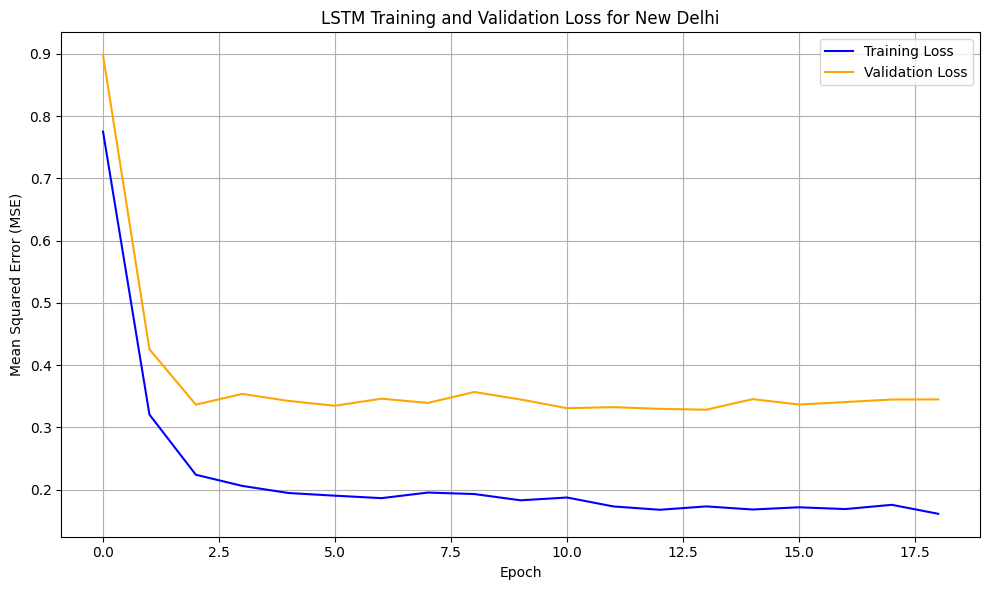


Displayed training/validation loss plot.

Validation MSE: 13.4511
Validation RMSE: 3.6676
Test MSE: 19.4230
Test RMSE: 4.4071


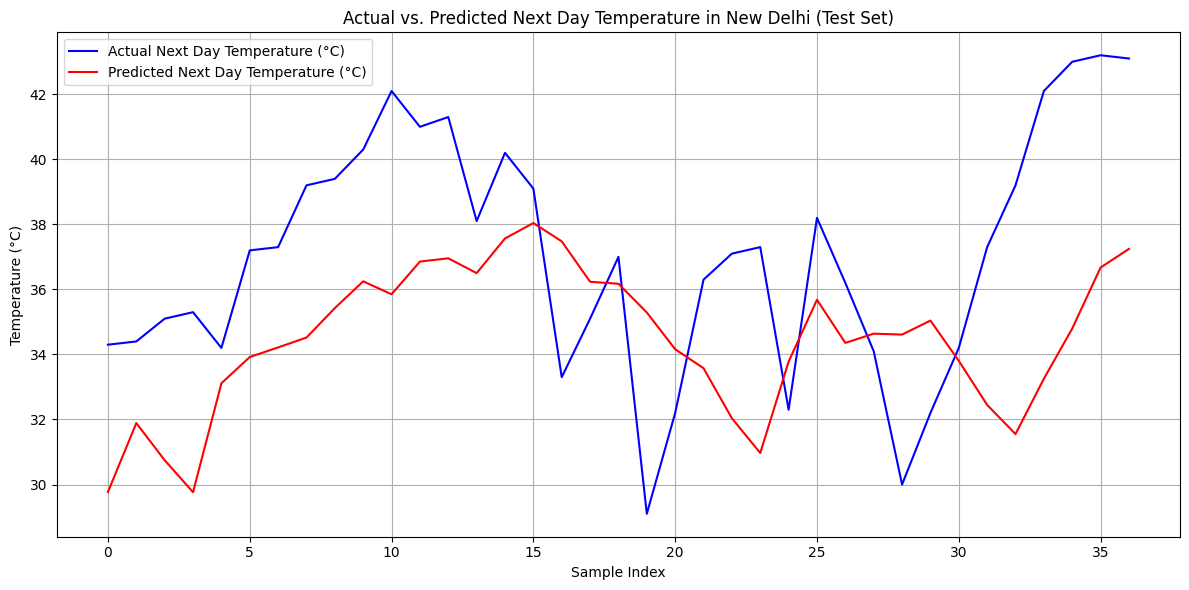


Displayed predictions vs. actuals plot.
Fold 1 MSE: 11.4893
Fold 2 MSE: 5.4377
Fold 3 MSE: 42.1810


Fold 4 MSE: 6.8399
Skipping fold 5 due to insufficient data.

Cross-Validation Mean MSE: 16.4870
Cross-Validation Mean RMSE: 4.0604

Model saved to /content/New Delhi_lstm_model.h5
Memory cleanup completed (except X_test_seq, y_test_seq).


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Install TensorFlow if not available
try:
    import tensorflow
except ImportError:
    !pip install tensorflow

# Load datasets
location = 'New Delhi'
train_path = f"/content/New Delhi_train_preprocessed.csv"
val_path = f"/content/New Delhi_val_preprocessed.csv"
test_path = f"/content/New Delhi_test_preprocessed.csv"

try:
    df_train = pd.read_csv(train_path, low_memory=False)
    df_val = pd.read_csv(val_path, low_memory=False)
    df_test = pd.read_csv(test_path, low_memory=False)
    print(f"Training set shape: {df_train.shape}")
    print(f"Validation set shape: {df_val.shape}")
    print(f"Test set shape: {df_test.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure preprocessed files exist.")
    exit()
except Exception as e:
    print(f"Error: {e} loading datasets.")
    exit()

# Check for empty DataFrames
if df_train.empty or df_val.empty or df_test.empty:
    print("Error: One or more datasets are empty.")
    exit()

# Verify target column
if 'next_day_temp' not in df_train.columns:
    print("Error: 'next_day_temp' not found in training dataset.")
    exit()

# Select features (exclude target)
features = [col for col in df_train.columns if col != 'next_day_temp']
print(f"\nSelected features: {len(features)}")
print(f"Features: {features}")

# Scale target
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(df_train['next_day_temp'].values.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(df_val['next_day_temp'].values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(df_test['next_day_temp'].values.reshape(-1, 1)).flatten()

# Prepare data for LSTM (3D: [samples, timesteps, features])
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 3  # Reduced for better pattern capture
X_train = df_train[features].values
X_val = df_val[features].values
X_test = df_test[features].values

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps) # This line defines X_test_seq

print(f"\nTraining sequences shape: {X_train_seq.shape}")
print(f"Validation sequences shape: {X_val_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

# Check for sufficient data
if X_train_seq.shape[0] == 0 or X_val_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
    print("Error: Insufficient data for sequences. Reduce time_steps or check dataset size.")
    exit()

# Build LSTM model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(time_steps, X_train_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# Train model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping]
)

# Plot training/validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'LSTM Training and Validation Loss for {location}')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()
print("\nDisplayed training/validation loss plot.")

# Walk-forward validation on validation set
val_predictions = model.predict(X_val_seq, verbose=0)
val_predictions = scaler_y.inverse_transform(val_predictions).flatten()
y_val_seq_unscaled = scaler_y.inverse_transform(y_val_seq.reshape(-1, 1)).flatten()
val_mse = mean_squared_error(y_val_seq_unscaled, val_predictions)
val_rmse = sqrt(val_mse)
print(f"\nValidation MSE: {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Evaluate on test set
test_predictions = model.predict(X_test_seq, verbose=0)
test_predictions = scaler_y.inverse_transform(test_predictions).flatten()
y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
test_mse = mean_squared_error(y_test_seq_unscaled, test_predictions)
test_rmse = sqrt(test_mse)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Plot predictions vs. actuals for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq_unscaled, label='Actual Next Day Temperature (°C)', color='blue')
plt.plot(test_predictions, label='Predicted Next Day Temperature (°C)', color='red')
plt.title(f'Actual vs. Predicted Next Day Temperature in {location} (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()
print("\nDisplayed predictions vs. actuals plot.")

# Time-series walk-forward validation
n_folds = 5
fold_size = len(X_train_seq) // n_folds
cv_mse_scores = []

for i in range(n_folds):
    train_end = (i + 1) * fold_size
    if train_end + time_steps >= len(X_train_seq):
        print(f"Skipping fold {i+1} due to insufficient data.")
        continue
    X_train_fold = X_train_seq[:train_end]
    y_train_fold = y_train_seq[:train_end]
    X_val_fold = X_train_seq[train_end:train_end + fold_size]
    y_val_fold = y_train_seq[train_end:train_end + fold_size]

    if X_val_fold.shape[0] == 0:
        print(f"Skipping fold {i+1} due to empty validation fold.")
        continue

    fold_model = Sequential([
        LSTM(50, activation='tanh', input_shape=(time_steps, X_train_seq.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    fold_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    fold_model.fit(
        X_train_fold, y_train_fold,
        epochs=10,
        batch_size=16,
        verbose=0,
        callbacks=[EarlyStopping(monitor='loss', patience=5)]
    )

    fold_predictions = fold_model.predict(X_val_fold, verbose=0)
    fold_predictions = scaler_y.inverse_transform(fold_predictions).flatten()
    y_val_fold_unscaled = scaler_y.inverse_transform(y_val_fold.reshape(-1, 1)).flatten()
    fold_mse = mean_squared_error(y_val_fold_unscaled, fold_predictions)
    cv_mse_scores.append(fold_mse)
    print(f"Fold {i+1} MSE: {fold_mse:.4f}")

if cv_mse_scores:
    mean_cv_mse = np.mean(cv_mse_scores)
    mean_cv_rmse = sqrt(mean_cv_mse)
    print(f"\nCross-Validation Mean MSE: {mean_cv_mse:.4f}")
    print(f"Cross-Validation Mean RMSE: {mean_cv_rmse:.4f}")
else:
    print("\nNo cross-validation scores computed due to insufficient data.")

# Save model
model.save(f"/content/{location}_lstm_model.h5")
print(f"\nModel saved to /content/{location}_lstm_model.h5")

# Memory cleanup
del df_train, df_val, df_test, X_train_seq, y_train_seq, X_val_seq, y_val_seq # Removed X_test_seq and y_test_seq from cleanup to use them in the next cell
print("Memory cleanup completed (except X_test_seq, y_test_seq).")


⏳ Starting 5-day temperature forecasting...
Reloaded test dataset for forecasting. Shape: (40, 13)

Features used for forecasting: 12
Features: ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_PM2.5', 'air_quality_us-epa-index']

📈 --- 5-Day Temperature Forecast ---
Day 1 (Day 1): 🔮 Predicted Temperature = 37.25 °C
Day 2 (Day 2): 🔮 Predicted Temperature = 37.12 °C
Day 3 (Day 3): 🔮 Predicted Temperature = 36.74 °C
Day 4 (Day 4): 🔮 Predicted Temperature = 36.10 °C
Day 5 (Day 5): 🔮 Predicted Temperature = 36.02 °C


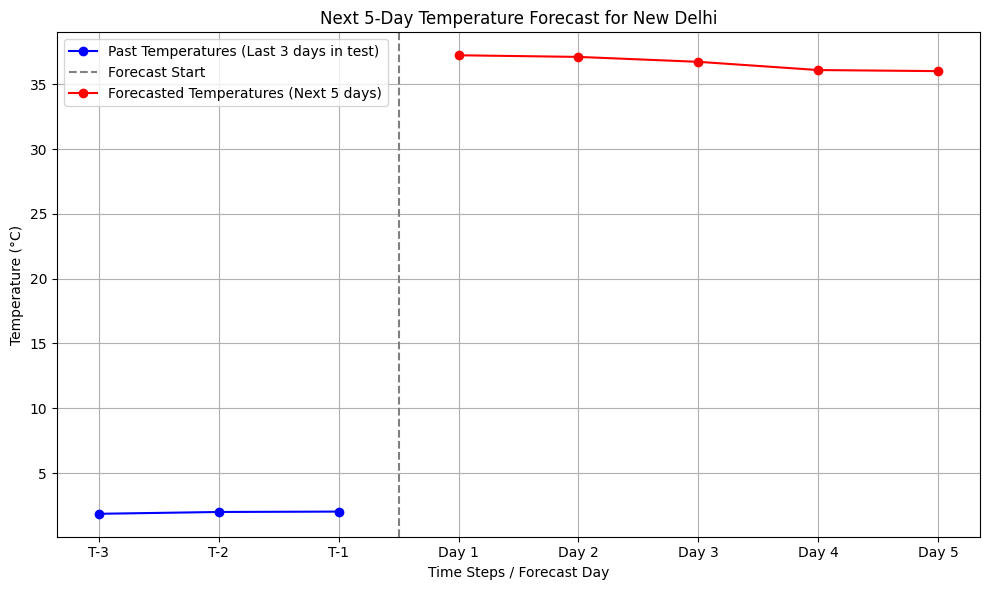


Forecast plot saved to /content/New Delhi_5day_forecast.png


<Figure size 640x480 with 0 Axes>

In [12]:
# ----------- 5-Day Forecasting Using Trained LSTM Model --------------
print("\n⏳ Starting 5-day temperature forecasting...")

# Load the test preprocessed dataset again to get column names and dates
# This is necessary because df_train and df_test were deleted previously
test_path = f"/content/New Delhi_test_preprocessed.csv"
try:
    df_test_plotting = pd.read_csv(test_path, low_memory=False)
    print(f"Reloaded test dataset for forecasting. Shape: {df_test_plotting.shape}")
except FileNotFoundError as e:
    print(f"Error reloading test dataset for forecasting: {e}")
    exit()
except Exception as e:
    print(f"Error reloading test dataset for forecasting: {e}")
    exit()

# Verify target column exists in the reloaded test data
if 'next_day_temp' not in df_test_plotting.columns:
    print("Error: 'next_day_temp' not found in reloaded test dataset.")
    exit()

# Redefine features list using columns from the reloaded test data
features_for_forecasting = [col for col in df_test_plotting.columns if col != 'next_day_temp']
print(f"\nFeatures used for forecasting: {len(features_for_forecasting)}")
print(f"Features: {features_for_forecasting}")


# Ensure X_test_seq is defined from the previous cell (it was excluded from cleanup)
if 'X_test_seq' not in locals() and 'X_test_seq' not in globals():
     print("Error: X_test_seq is not defined. Rerun the previous cell to generate it.")
     exit()

# Last known window from test data
last_window = X_test_seq[-1]  # shape: (time_steps, num_features)
forecast_input = last_window.copy()
forecast_sequence = []

# Find the index of 'temperature_celsius' in the features list
try:
    temp_index = features_for_forecasting.index('temperature_celsius')
except ValueError:
    print("Error: 'temperature_celsius' not found in features list used for forecasting. Cannot update forecast input.")
    exit()


for day in range(5):
    input_reshaped = forecast_input.reshape(1, time_steps, X_test_seq.shape[2])

    # Predict the next day's scaled temperature
    next_scaled = model.predict(input_reshaped, verbose=0)[0][0]

    # Store prediction
    forecast_sequence.append(next_scaled)

    # Build new input by sliding window and adding new predicted temperature
    next_input_step = forecast_input[-1].copy()
    # Replace the temperature value at the correct index
    next_input_step[temp_index] = next_scaled

    forecast_input = np.vstack([forecast_input[1:], next_input_step])  # Slide the window

# Inverse transform predictions to get actual temperatures
predictions_actual = scaler_y.inverse_transform(np.array(forecast_sequence).reshape(-1, 1)).flatten()

# Get future dates. Use the reloaded test dataframe
try:
    # Convert 'last_updated' to datetime in the reloaded dataframe
    df_test_plotting['last_updated'] = pd.to_datetime(df_test_plotting['last_updated'])
    # The last sequence in X_test_seq corresponds to the last `time_steps` rows
    # of the *unsequenced* test dataframe, right before the last `next_day_temp` was defined.
    # The forecast starts from the day *after* the last date in df_test_plotting.
    last_date_in_test = df_test_plotting['last_updated'].iloc[-1]
    future_dates = pd.date_range(start=last_date_in_test + pd.Timedelta(days=1), periods=5).strftime('%Y-%m-%d') # Format dates
except (KeyError, IndexError) as e:
    # Fallback if 'last_updated' is not available or df_test_plotting is too short
    print(f"Warning: Could not determine future dates from df_test_plotting: {e}. Using generic 'Day X' labels.")
    future_dates = [f"Day {i+1}" for i in range(5)]
except Exception as e:
    print(f"Unexpected error determining future dates: {e}. Using generic 'Day X' labels.")
    future_dates = [f"Day {i+1}" for i in range(5)]


# --- Display Forecast ---
print("\n📈 --- 5-Day Temperature Forecast ---")
for i, (d, p) in enumerate(zip(future_dates, predictions_actual)):
    print(f"Day {i+1} ({d}): 🔮 Predicted Temperature = {p:.2f} °C")

# --- Plotting Forecast ---
plt.figure(figsize=(10, 6))

# Past inputs (time_steps days before prediction)
# Use the reloaded df_test_plotting to get the actual past temperatures for plotting
try:
    # Get the last 'time_steps' actual temperature values from the reloaded df_test_plotting
    if len(df_test_plotting) >= time_steps:
         past_actual_temps = df_test_plotting['temperature_celsius'].values[-time_steps:]
         # Generate indices relative to forecast start (e.g., -3, -2, -1)
         past_indices = range(-time_steps, 0)
         plt.plot(past_indices, past_actual_temps, marker='o', label=f'Past Temperatures (Last {time_steps} days in test)', color='blue')
         plt.axvline(x=-0.5, color='gray', linestyle='--', label='Forecast Start') # Forecast starts after index -1
    else:
         print(f"Warning: Not enough data in reloaded df_test_plotting ({len(df_test_plotting)} rows) to plot last {time_steps} past temperatures.")
         past_indices = [] # Ensure past_indices is defined even if empty
         past_actual_temps = []


except Exception as e:
     print(f"Error preparing past temperatures for plotting from reloaded df_test_plotting: {e}")
     past_indices = []
     past_actual_temps = []


# Forecast plotted starting after the last past data point
# The forecast indices should start from 0 relative to the forecast start line
forecast_indices = range(0, 5) # Indices for the 5 forecast days (0 to 4)

plt.plot(forecast_indices, predictions_actual, marker='o', label='Forecasted Temperatures (Next 5 days)', color='red')

# Combine indices for x-axis ticks
all_indices = list(past_indices) + list(forecast_indices)
# Create corresponding labels. Past: T-3, T-2, T-1. Forecast: Day 1, Day 2, ... Day 5
all_labels = [f"T{n}" for n in past_indices] + [f"Day {n+1}" for n in forecast_indices]


plt.xticks(ticks=all_indices, labels=all_labels)
plt.title(f"Next 5-Day Temperature Forecast for {location}")
plt.xlabel("Time Steps / Forecast Day")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save plot
try:
    plt.savefig(f"/content/{location}_5day_forecast.png")
    print(f"\nForecast plot saved to /content/{location}_5day_forecast.png")
except Exception as e:
    print(f"Error saving plot: {e}")

# Optional: Clean up the reloaded dataframe if memory is a concern
# del df_test_plotting
# print("Reloaded df_test_plotting cleaned up.")